# [Numba](https://lectures.quantecon.org/py/numba.html)
## 1. Overview

In our lecture on [NumPy](https://lectures.quantecon.org/py/numpy.html) we learned one method to **improve speed and efficiency in numerical work**

That method, called *vectorization*, involved sending array processing operations in batch to efficient low level code

In the last few years, a new Python library called [Numba](http://numba.pydata.org/) has appeared that solves many of these problems

It does so through something called **just in time (JIT) compilation**  

## 2.Where are the Bottlenecks?
### Dynamic Typing

In [1]:
a, b = 10, 10
a + b

20

In [2]:
a, b = 'foo', 'bar'
a + b

'foobar'

In [3]:
a, b = ['foo'], ['bar']
a + b

['foo', 'bar']

#### Static Types
For example, consider the following C code, which sums the integers from 1 to 10  
The variables `i` and `sum` are explicitly declared to be integers

```
#include <stdio.h>

int main(void) {
    int i;
    int sum = 0;
    for (i = 1; i <= 10; i++) {
        sum = sum + i;
    }
    printf("sum = %d\n", sum);
    return 0;
}
```

### Data Access
#### Summing with Compiled Code
#### Summing in Pure Python
Python在速度方面或有欠缺
## 3. Vectorization
### Operations on Arrays

In [4]:
import random
import numpy as np
import quantecon as qe         # v 0.3.8 会报错，v 0.3.7 可以

Now let’s try this non-vectorized code

In [5]:
qe.tic()   # Start timing
n = 100_000
sum = 0
for i in range(n):
    x = random.uniform(0, 1)
    sum += x**2
qe.toc()   # End timing

TOC: Elapsed: 0:00:0.07


'0.07'

Now compare this vectorized code

In [6]:
qe.tic()
n = 100_000
x = np.random.uniform(0, 1, n)
np.sum(x**2)
qe.toc()

TOC: Elapsed: 0:00:0.00


'0.00'

Vectorized code is typically fast and efficient

It is also surprisingly flexible, in the sense that many operations can be vectorized

### Universal Functions 
Many functions provided by NumPy are so-called universal functions — also called `ufuncs`    
For example, `np.cos` is a `ufunc`:

In [7]:
np.cos(1.0)

0.54030230586813977

In [8]:
np.cos(np.linspace(0, 1, 3))

array([ 1.        ,  0.87758256,  0.54030231])

For example, consider the problem of maximizing a function f of two variables `(x,y)` over the square `[−a,a]×[−a,a]`

For `f` and `a` let’s choose  

<center>$ f(x,y) = \frac{cos(x^2+y^2)}{1+x^2+y^2}\ and \ a=3$</center>  

Here’s a plot of `f`

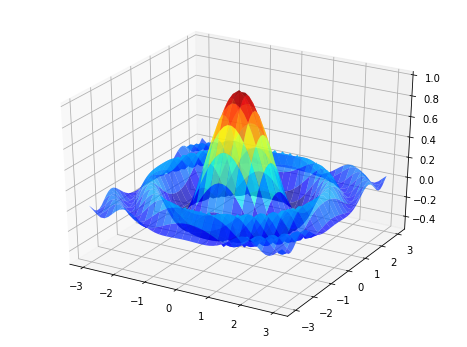

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

xgrid = np.linspace(-3, 3, 50)
ygrid = xgrid
x, y = np.meshgrid(xgrid, ygrid)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                f(x, y),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.7,
                linewidth=0.25)
ax.set_zlim(-0.5, 1.0)
plt.show()

To **maximize** it, we’re going to use a naive grid search:

   1. Evaluate `f` for all `(x,y)` in a grid on the square
   2. Return the maximum of observed values

Here’s a non-vectorized version that uses Python loops

In [10]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 1000)
m = -np.inf          # inf 无穷

qe.tic()
for x in grid:
    for y in grid:
        z = f(x, y)
        if z > m:
            m = z

qe.toc()

TOC: Elapsed: 0:00:2.71


'2.72'

In [11]:
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)

qe.tic()
np.max(f(x, y))
qe.toc()

TOC: Elapsed: 0:00:0.06


'0.07'

### Pros and Cons of Vectorization
At its best, vectorization yields fast, simple code

However, it’s not without disadvantages

One issue is that it can be highly memory intensive

Another issue is that not all algorithms can be vectorized
## 4.Numba
### Prerequisites
`conda install numba`  
`conda update anaconda` 
### An Example
Let’s take the difference equation to be the quadratic map 
<center>$x_{t+1}=4x_t(1-x_t)$</center>  
Here’s the plot of a typical trajectory, starting from $x_0=0.1$, with $t$ on the x-axis

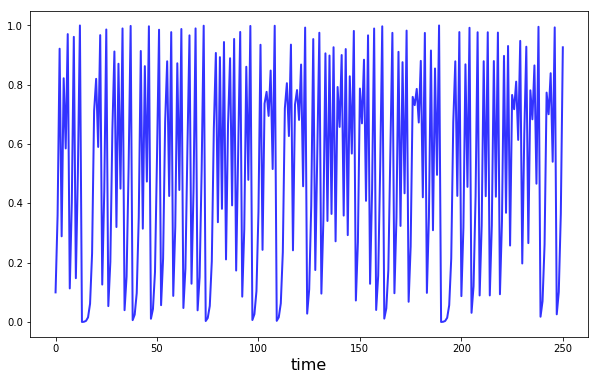

In [12]:
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x

x = qm(0.1, 250)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, 'b-', lw=2, alpha=0.8)
ax.set_xlabel('time', fontsize=16)
plt.show()

To speed this up using Numba is trivial using Numba’s `jit` function

In [13]:
from numba import jit

qm_numba = jit(qm)     # qm_numba is now a 'compiled' version of qm

In [14]:
qe.util.tic()
qm(0.1, int(10**6))
time1 = qe.util.toc()


TOC: Elapsed: 0:00:1.22


In [15]:
qe.util.tic()
qm_numba(0.1, int(10**6))
time2 = qe.util.toc()

TOC: Elapsed: 0:00:0.08


The first execution is relatively slow because of JIT compilation (see below)

Next time and all subsequent times it runs much faster:

In [16]:
qe.util.tic()
qm_numba(0.1, int(10**6))
time2 = qe.util.toc()
time2

TOC: Elapsed: 0:00:0.01


'0.01'

```
time1 / time2   # Calculate speed gain
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-17-50fee0c0fd4a> in <module>()
----> 1 time1 / time2   # Calculate speed gain

TypeError: unsupported operand type(s) for /: 'str' and 'str'
```

In [17]:
from functools import reduce

def str2float(s):

    def f(s):
        return {'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '.': '.'}[s]
    def g(x, y):
        return x*10 + y
    pos = s.find('.')
    front = reduce(g,map(f,s[0:pos]))
    rear = reduce(g,map(f,s[pos+1:]))/10**(len(s)-pos-1)
    return front+rear

print('str2float(\'123.456\') =', str2float('123.456'))

str2float('123.456') = 123.456


In [18]:
str2float(time1)/str2float(time2)

123.0

#### Decorator Notation
If you don’t need a separate name for the “numbafied” version of qm, you can just put `@jit` before the function

In [19]:
@jit
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x

### How and When it Works
#### A Gotcha: Global Variables

In [20]:
a = 1

@jit
def add_x(x):
    return a + x

print(add_x(10))

11


In [21]:
a = 2
print(add_x(10))

11


Notice that changing the global had no effect on the value returned by the function

When Numba compiles machine code for functions, it treats global variables as constants to ensure type stability

#### Numba for vectorization

In [22]:
from numba import vectorize

@vectorize
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)

np.max(f_vec(x, y))  # Run once to compile

qe.tic()
np.max(f_vec(x, y))
qe.toc()

TOC: Elapsed: 0:00:0.01


'0.02'

For example, when NumPy computes `np.cos(x**2 + y**2)` it first creates the intermediate arrays `x**2` and `y**2`, then it creates the array `np.cos(x**2 + y**2)`

In our `@vectorize` version using Numba, the entire operator is reduced to a single vectorized process and none of these intermediate arrays are created


We can gain further speed improvements using Numba’s automatic parallelization feature by specifying `target=’parallel’`

In [23]:
@vectorize('float64(float64, float64)', target='parallel')
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

np.max(f_vec(x, y))  # Run once to compile

qe.tic()
np.max(f_vec(x, y))
qe.toc()

TOC: Elapsed: 0:00:0.01


'0.02'